In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

root_path = "/data/mm/sr-press"
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
print(f"root_path: {root_path}")
sys.path.append(base_path)
sys.path.append(root_path)

base_path: /home/ubuntu/LMH/sr-press
root_path: /data/mm/sr-press


In [2]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier

In [3]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names

/home/ubuntu/miniforge3/envs/mm/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
# TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
TRAIN_DB_PATH = os.path.join(root_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(root_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f12b284d060>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f12b284d090>


In [10]:
# dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
# dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))
dataset_train = partial(PressingDataset, path=os.path.join(root_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(root_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/data/mm/sr-press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/data/mm/sr-press/stores/datasets/test')


In [6]:
# xgboost, symbolic_regression
test_dataset = PressingDataset(
    # path= os.path.join(base_path, "stores", "datasets", "test"),
    path= os.path.join(root_path, "stores", "datasets", "test"),
    # xfns=["startlocation", "closest_11_players"],
    xfns=["startlocation", "freeze_frame_360"],
    yfns=["counterpress"],
    # yfns=["concede_shots"],
    load_cached=True,
    nb_prev_actions=3
)

# soccermap
# test_dataset = PressingDataset(
#     path= os.path.join(base_path, "stores", "datasets", "test"),
#     xfns=["startlocation", "freeze_frame_360"],
#     yfns=["counterpress"],
#     load_cached=True,
#     nb_prev_actions=1
# )

print(f"Test DataSet: {test_dataset.features.shape}")
print(f"Test Dataset: {test_dataset.labels.value_counts().to_dict()}")

Test DataSet: (12406, 9)
Test Dataset: {(False,): 9954, (True,): 2452}


In [7]:
model = "xgboost" #"soccermap"
trial = 503
save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
if os.path.exists(save_path):
    print(save_path)
else:
    print("Path Error")

/home/ubuntu/LMH/sr-press/stores/model/xgboost/503/component.pkl


In [8]:
from express.components.base import exPressComponent
import pickle
from pathlib import Path

path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [11]:
component.test(dataset_train)

{'precision': 0.863928748144483,
 'recall': 0.7039376427899476,
 'f1': 0.7757701421800948,
 'log_loss': 0.20296205532855557,
 'brier': 0.0589724167690651,
 'roc_auc': 0.9617237333202706}

In [12]:
component.test(dataset_test)

{'precision': 0.7124582869855395,
 'recall': 0.5224306688417618,
 'f1': 0.6028235294117648,
 'log_loss': 0.31629473141861647,
 'brier': 0.09718685378148281,
 'roc_auc': 0.8902740534681394}

In [13]:
game_id = 3895202

df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895202,0,b98b3109-8cb2-4017-8960-a8cb2a1937c1,1,0.575,182,39167,52.0625,34.425,49.2625,...,From Kick Off,0,0.440712,"{'pass': {'recipient': {'id': 16532, 'name': '...",None,0,None,pass,success,foot_left
1,3895202,1,c2231776-f3ce-43d6-b431-0af2dc65c313,1,1.016,182,16532,49.2625,31.875,48.5625,...,From Kick Off,0,0.120000,"{'carry': {'end_location': [56.0, 43.0]}}",None,0,None,dribble,success,foot
2,3895202,2,04aea3ae-64dc-4ec8-aca8-96f72f4ffa44,1,1.136,182,16532,48.5625,31.875,51.7125,...,From Kick Off,0,0.582041,"{'pass': {'recipient': {'id': 39167, 'name': '...",None,0,None,pass,success,foot_right
3,3895202,3,e8417cec-49aa-4d9f-89ee-b6fca968081d,1,1.718,182,39167,51.7125,34.000,51.1000,...,From Kick Off,0,0.160000,"{'carry': {'end_location': [58.9, 40.5]}}",None,0,None,dribble,success,foot
4,3895202,4,c10715ad-d07f-4a7e-afa1-591d47148016,1,1.878,182,39167,51.1000,34.000,40.6875,...,From Kick Off,0,0.863635,"{'pass': {'recipient': {'id': 39460, 'name': '...",None,0,None,pass,success,foot_right


In [14]:
df_actions[df_actions['original_event_id'] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"].index[0]

555

### Visualization

In [15]:
data = component.initialize_dataset(dataset_test)
X_test, y_test = data.features, data.labels
# X_test = X_test.reset_index()

In [20]:
df_actions[df_actions['original_event_id'] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"]

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
555,3895202,555,c2d74b65-f31d-4d50-a027-fb42fec6ac60,1,973.716,182,39460,53.1125,34.51,53.1125,...,From Free Kick,0,0.321153,{},"[[45.70343873800862, 12.94260716187194], [39.3...",1,"[{'teammate': False, 'actor': False, 'keeper':...",pressing,fail,foot


In [ ]:
pressure_row = df_actions[df_actions['original_event_id'] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"]

# MultiIndex를 DataFrame 형태로 리셋
X_test_reset = X_test.reset_index()

# 조건 기반 필터링
X_test_pressure = X_test_reset[
    (X_test_reset['game_id'] == pressure_row['game_id'].iloc[0]) &
    (X_test_reset['action_id'] == pressure_row['action_id'].iloc[0])
].set_index(["game_id", "action_id"])

component.model.predict_proba(X_test_pressure)[:, 1]

array([0.12175824], dtype=float32)

In [51]:
X_test_pressure['teammate_1_x_a0'], X_test_pressure['teammate_1_y_a0']

(game_id  action_id
 3895202  555          58.386763
 Name: teammate_1_x_a0, dtype: float64,
 game_id  action_id
 3895202  555          33.644227
 Name: teammate_1_y_a0, dtype: float64)

In [36]:
y_test.loc[pressure_row['game_id'].iloc[0],
    pressure_row['action_id'].iloc[0]]

counterpress    False
Name: (3895202, 555), dtype: bool

In [40]:
freeze_frame = pd.DataFrame.from_records(df_actions.loc[idx]['freeze_frame_360'])
freeze_frame

,teammate,actor,keeper,x,y
0,True,False,False,63.068898,38.443145
1,True,False,False,62.059875,28.309583
2,True,False,False,58.330044,50.941976
3,False,False,False,57.095208,33.809417
4,False,False,False,56.372985,44.958242
5,True,False,False,55.219196,42.150664
6,True,True,False,55.212499,34.679999
7,False,False,False,53.937279,34.735545
8,False,False,False,53.446130,25.906619
9,True,False,False,53.136673,12.197567


In [ ]:
teammate_locs = freeze_frame[freeze_frame.teammate].copy()
opponent_locs = freeze_frame[~freeze_frame.teammate].copy()
event_player_loc = freeze_frame[freeze_frame.actor].copy()


In [46]:
import numpy as np

def calculate_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

teammate_locs['distance'] = teammate_locs.apply(lambda row: calculate_distance(df_actions.loc[idx].start_x, df_actions.loc[idx].start_y, row.x, row.y), axis=1)
closest_teammates = teammate_locs.nsmallest(3, 'distance')

# Calculate distances to opponents
opponent_locs['distance'] = opponent_locs.apply(lambda row: calculate_distance(df_actions.loc[idx].start_x, df_actions.loc[idx].start_y, row.x, row.y), axis=1)
closest_opponents = opponent_locs.nsmallest(3, 'distance')

closest_teammates

,teammate,actor,keeper,x,y,distance
6,True,True,False,55.212499,34.679999,0.609944
5,True,False,False,55.219196,42.150664,7.907408
0,True,False,False,63.068898,38.443145,8.519425


In [ ]:
closest_teammates.iloc[]

,teammate,actor,keeper,x,y,distance
6,True,True,False,55.212499,34.679999,0.609944
5,True,False,False,55.219196,42.150664,7.907408
0,True,False,False,63.068898,38.443145,8.519425


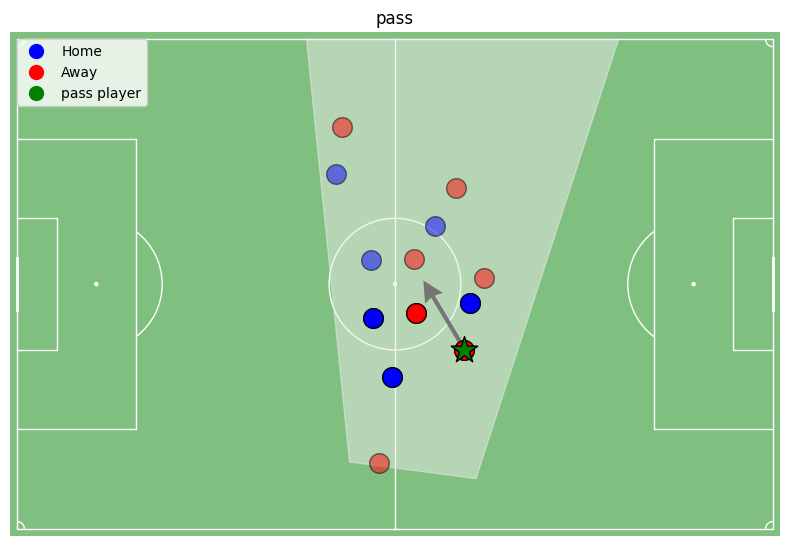

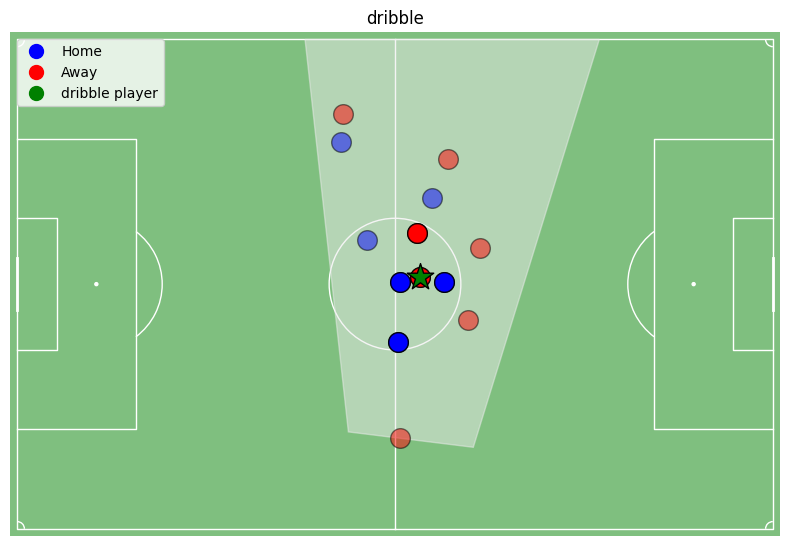

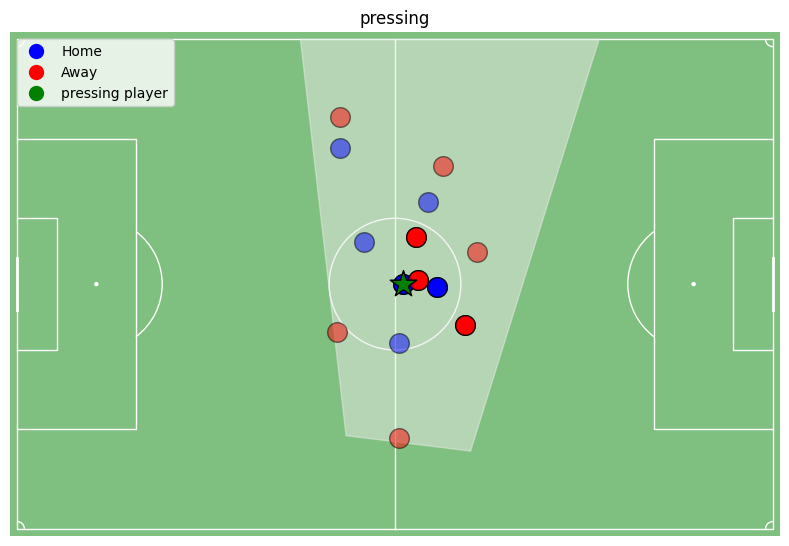

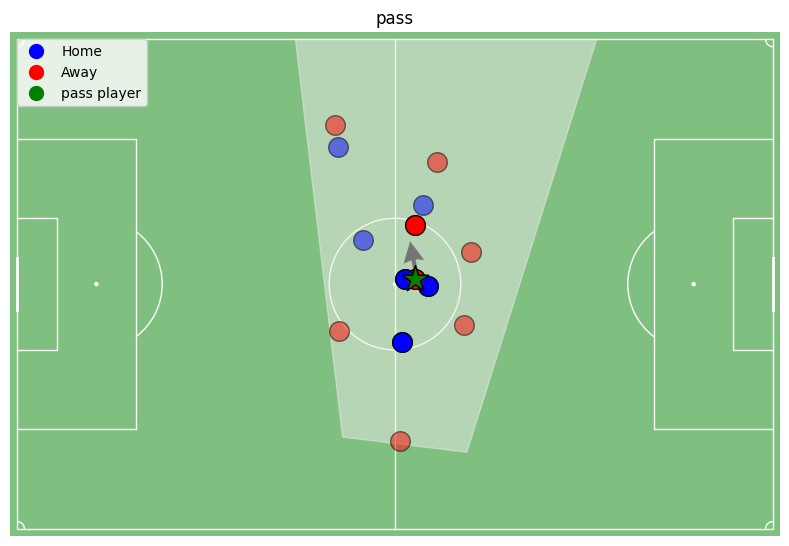

In [47]:
# pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
pressure_idx = df_actions[df_actions['original_event_id'] == "c2d74b65-f31d-4d50-a027-fb42fec6ac60"].index[0]
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)